# Quora Insincere Questions Classification: 1

## 1. Business/Real-world Problem

### 1.1 Description

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

Credits: Kaggle

__Problem Statement__

- Detect toxic content to improve online conversations.
- We have to develop models that identify and flag insincere questions.
- Source: https://www.kaggle.com/c/quora-insincere-questions-classification

### 1.2 Real world/Business Objectives and Constraints

- The cost of a mis-classification can be very high.
- No strict latency concerns.
- Interpretability is partially important 

## 2. Machine Learning Problem

### 2.1 Data Overview

__General Description__

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
    - Has an exaggerated tone to underscore a point about a group of people
     - Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory
    - Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
    - Makes disparaging attacks/insults against a specific person or group of people
    - Based on an outlandish premise about a group of people
    - Disparages against a characteristic that is not fixable and not measurable
- Isn't grounded in reality
    - Based on false information, or contains absurd assumptions
- Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

__File Description__
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - A sample submission in the correct format

__Data fields__
- qid - unique question identifier
- question_text - Quora question text
- target - a question labeled "insincere" has a value of 1, otherwise 0

### 2.2 Mapping the real world problem to an ML problem

#### 2.2.1 Type of Machine Learning Problem
It is a binary classification problem, for a given question we need to predict if it is **insincere** question or not.

#### 2.2.2 Performance Metric

Source: https://www.kaggle.com/c/quora-insincere-questions-classification/overview/evaluation

- [F1 Score](https://en.wikipedia.org/wiki/F1_score)


**NOTE**: Some quesiton text in the notebook may be offensive.

## 3. Exploratory Data Analysis

#### 3.1 Loading python libraries

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import csv
import string
import gc
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import hstack
from IPython.display import Image
from prettytable import PrettyTable

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams

Using TensorFlow backend.


In [0]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### 3.2 Reading data and basic stats

In [0]:
path = '' #'../input/'

df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

print("Number of data points in training data:", df_train.shape[0])
print("Number of data points in test data:", df_test.shape[0])

Number of data points in training data: 1306122
Number of data points in test data: 375806


In [0]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [0]:
# Checking for null values.

df_train['question_text'].isnull().sum(), df_test['question_text'].isnull().sum() 

(0, 0)

#### 3.3 Distribution of data points among output class

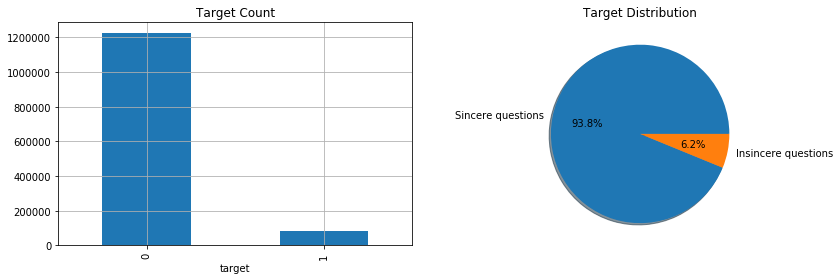

In [0]:
# Bar chart
plt.subplot(1, 2, 1)
df_train.groupby('target')['qid'].count().plot.bar()
plt.grid(True)
plt.title('Target Count')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
values = [df_train[df_train['target']==0].shape[0], df_train[df_train['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Target Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

__Observations:__  
- Data is highly imbalanced with only 6.2% of insincere questions.

#### 3.4 Word cloud for both sincere and insincere questions

In [0]:
def display_wordcloud(data, title):
    words_list = data.unique().tolist()
    words = ' '.join(words_list)
    
    wordcloud = WordCloud(width = 800, height = 400,
                      stopwords = set(STOPWORDS)).generate(words)

    plt.figure(figsize=(20, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f'Words in {title}')
    plt.axis("off")
    plt.show()

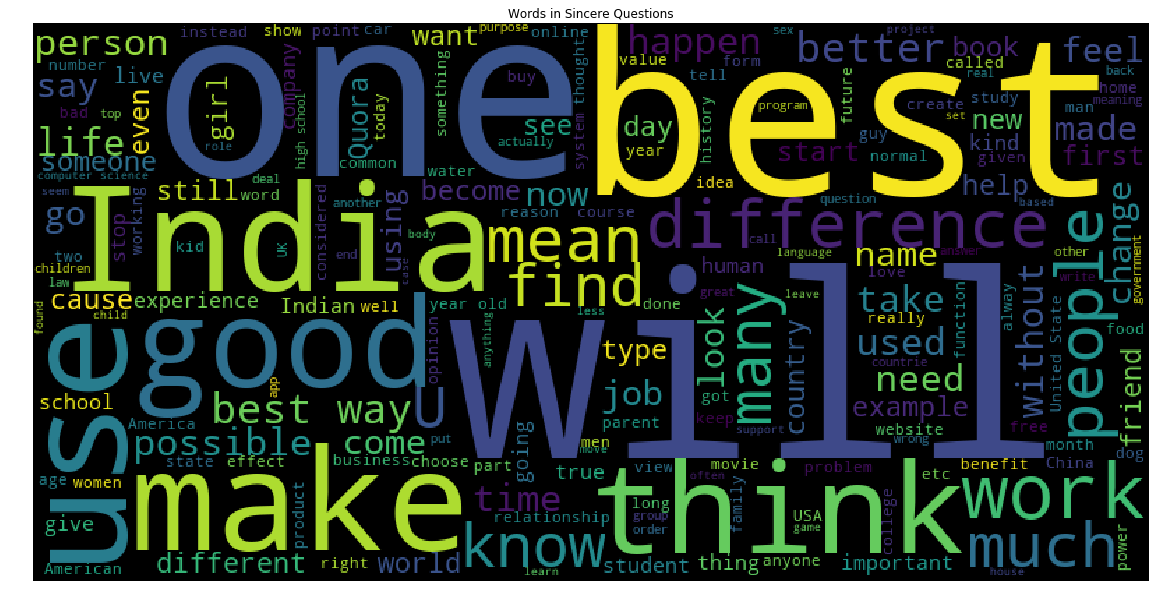

In [0]:
# Wordcloud for Sincere Questions
display_wordcloud(df_train[df_train['target']==0]['question_text'], 'Sincere Questions')

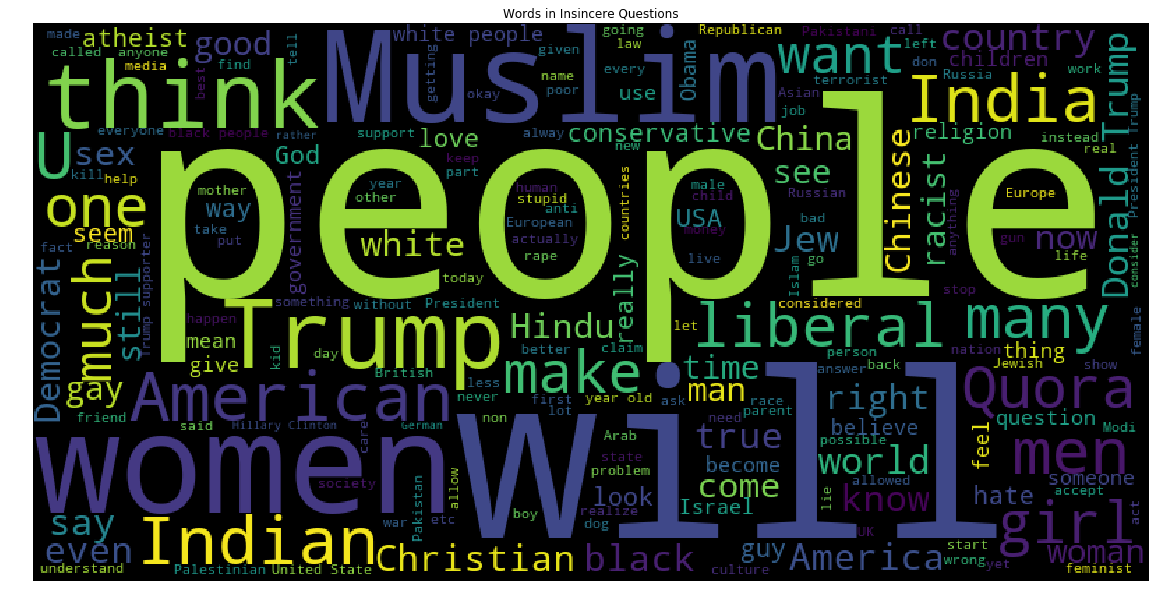

In [0]:
# Wordcloud for Insincere Questions
display_wordcloud(df_train[df_train['target']==1]['question_text'], 'Insincere Questions')

__Observations:__
- As we can see insincere questions contain many of the offensive words.
- Most of the questions are related to *People*, *Muslim*,  *Women*, *Trump*, etc.

#### 3.5 Top words in both sincere and insincere questions (Unigrams|Bigrams|Trigrams)

In [0]:
from collections import Counter

def plot_word_freq(data, title, bar_color):
    
  top_words = Counter(data).most_common(25) #top 25 words

  df_top = pd.DataFrame(top_words, columns=['word', 'count']).sort_values('count') # storing in df

  plt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=bar_color) # plot
  plt.title(f'Top words in {title}')

In [0]:
def get_unigrams(data):
  unigrams = []
  for sent in data:
    unigrams.extend([w for w in sent.lower().split() if w not in STOPWORDS])
  return unigrams

def get_bigrams(data):
  bigrams = []
  for sent in data:
    sent = [w for w in sent.lower().split() if w not in STOPWORDS]
    bi = [b for b in nltk.bigrams(sent)]
    bi = [' '.join(w) for w in bi]
    bigrams.extend(bi)
  return bigrams
    
def get_trigrams(data):
  trigrams = []
  for sent in data:
    sent = [w for w in sent.lower().split() if w not in STOPWORDS]
    ti = [t for t in nltk.trigrams(sent)]
    ti = [' '.join(w) for w in ti]
    trigrams.extend(ti)
  return trigrams

In [0]:
# Unigrams
unigrams_sincere  = get_unigrams(df_train[df_train['target']==0]['question_text'])
unigrams_insincere = get_unigrams(df_train[df_train['target']==1]['question_text'])

# Bigrams
bigrams_sincere = get_bigrams(df_train[df_train['target']==0]['question_text'])
bigrams_insincere = get_bigrams(df_train[df_train['target']==1]['question_text'])

# Trigrams
trigrams_sincere = get_trigrams(df_train[df_train['target']==0]['question_text'])
trigrams_insincere = get_trigrams(df_train[df_train['target']==1]['question_text'])

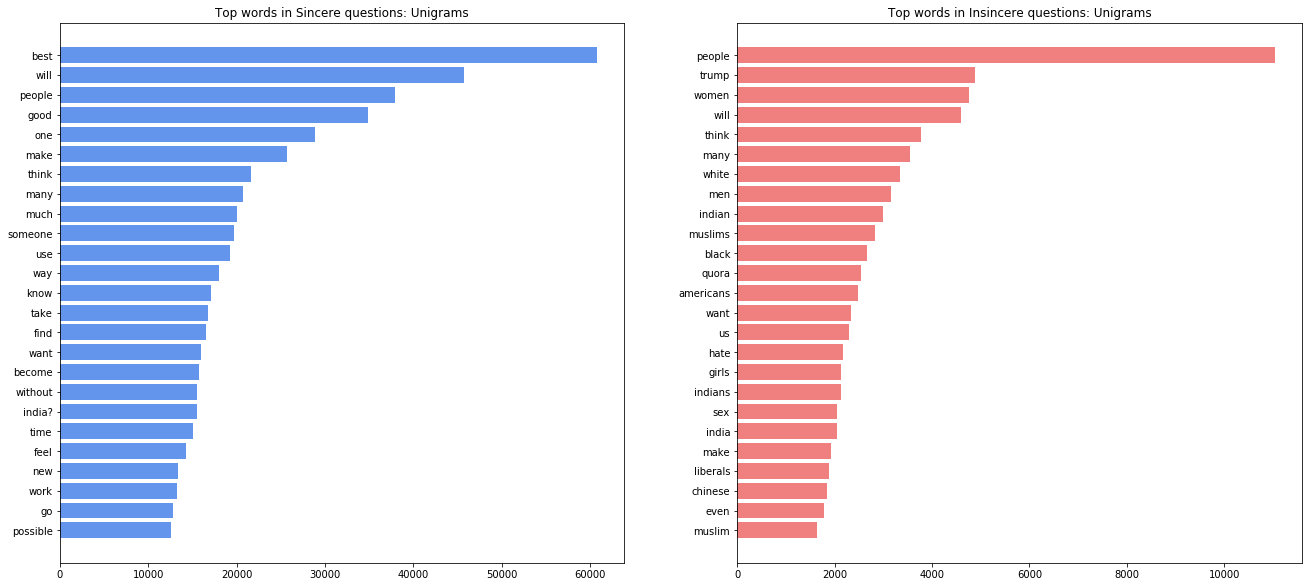

In [0]:
# Unigrams Sincere words
plt.subplot(1, 2, 1)
plot_word_freq(unigrams_sincere, 'Sincere questions: Unigrams', 'cornflowerblue')

# Unigrams Insincere words
plt.subplot(1, 2, 2)
plot_word_freq(unigrams_insincere, 'Insincere questions: Unigrams', 'lightcoral')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

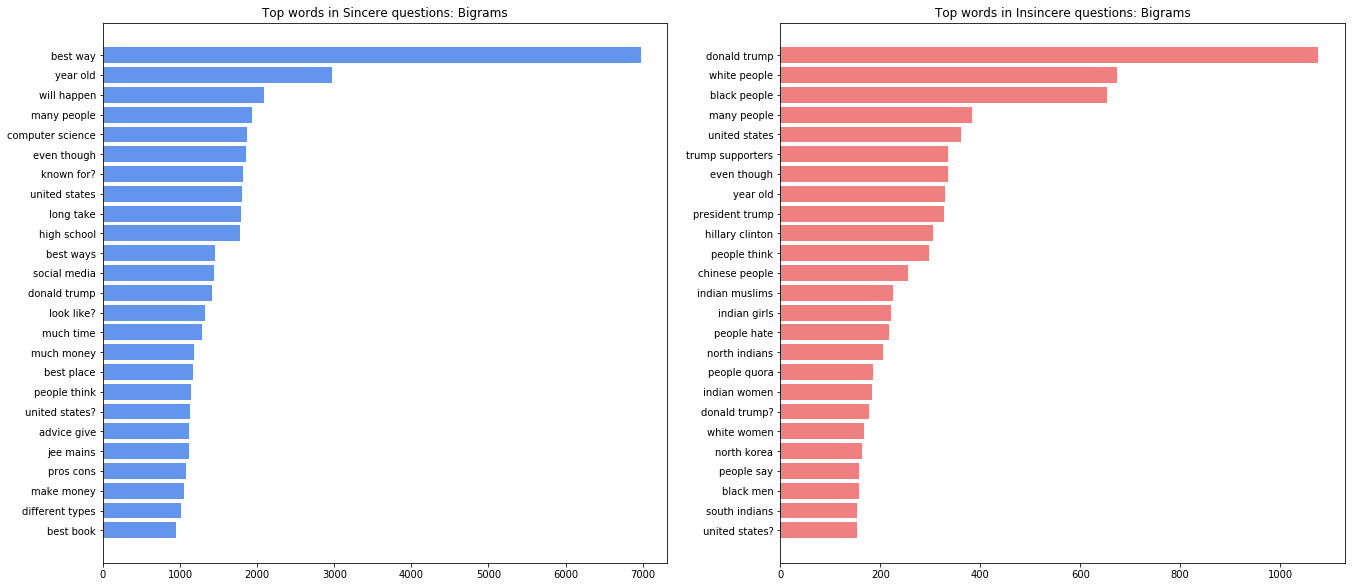

In [0]:
# Bigrams Sincere words
plt.subplot(1, 2, 1)
plot_word_freq(bigrams_sincere, 'Sincere questions: Bigrams', 'cornflowerblue')

# Bigrams Insincere words
plt.subplot(1, 2, 2)
plot_word_freq(bigrams_insincere, 'Insincere questions: Bigrams', 'lightcoral')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

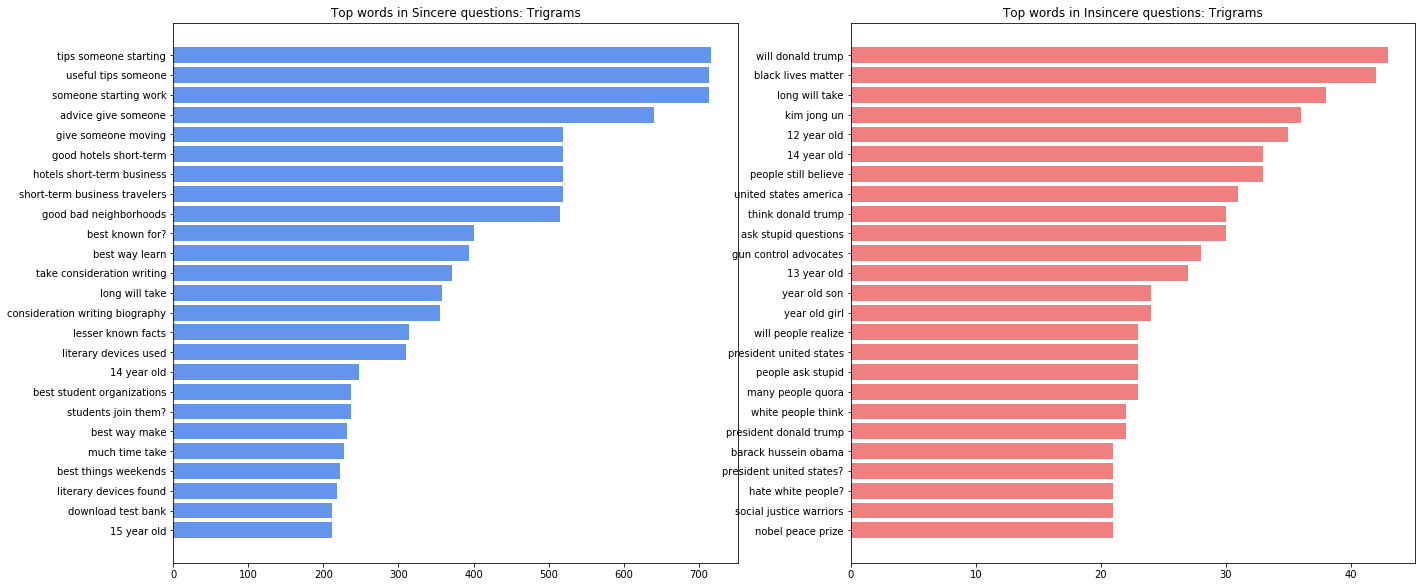

In [0]:
# Trigrams Sincere words
plt.subplot(1, 2, 1)
plot_word_freq(trigrams_sincere, 'Sincere questions: Trigrams', 'cornflowerblue')

# Trigrams Insincere words
plt.subplot(1, 2, 2)
plot_word_freq(trigrams_insincere, 'Insincere questions: Trigrams', 'lightcoral')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

#### 3.6 Basic Feauture Extraction(before cleaning)

Let's construct few basic features like:
- Number of words
- Number of capital_letters
- Number of special characters
- Number of unique words
- Number of numerics
- Number of characters
- Number of stopwords

In [0]:
# https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

# Number of words
df_train['num_words'] = df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['question_text'].apply(lambda x: len(str(x).split()))

# Number of capital_letters
df_train['num_capital_let'] = df_train['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
df_test['num_capital_let'] = df_test['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))

# Number of special characters
df_train['num_special_char'] = df_train['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
df_test['num_special_char'] = df_test['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

# Number of unique words
df_train['num_unique_words'] = df_train['question_text'].apply(lambda x: len(set(str(x).split())))
df_test['num_unique_words'] = df_test['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of numerics
df_train['num_numerics'] = df_train['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
df_test['num_numerics'] = df_test['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

# Number of characters
df_train['num_char'] = df_train['question_text'].apply(lambda x: len(str(x)))
df_test['num_char'] = df_test['question_text'].apply(lambda x: len(str(x)))

# Number of stopwords
df_train['num_stopwords'] = df_train['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
df_test['num_stopwords'] = df_test['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))

df_train.head()

,qid,question_text,target,num_words,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,num_stopwords
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,7
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,10
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,3
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,3
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,7


#### 3.7 Analysis on extracted features.

In [0]:
print("Minimum length of a question:", min(df['num_words']))
print("Maximum length of a question:", max(df['num_words']))

Minimum length of a question: 1
Maximum length of a question: 134


In [0]:
def display_boxplot(_x, _y, _data, _title):
    sns.boxplot(x=_x, y=_y, data=_data)
    plt.grid(True)
    plt.title(_title)

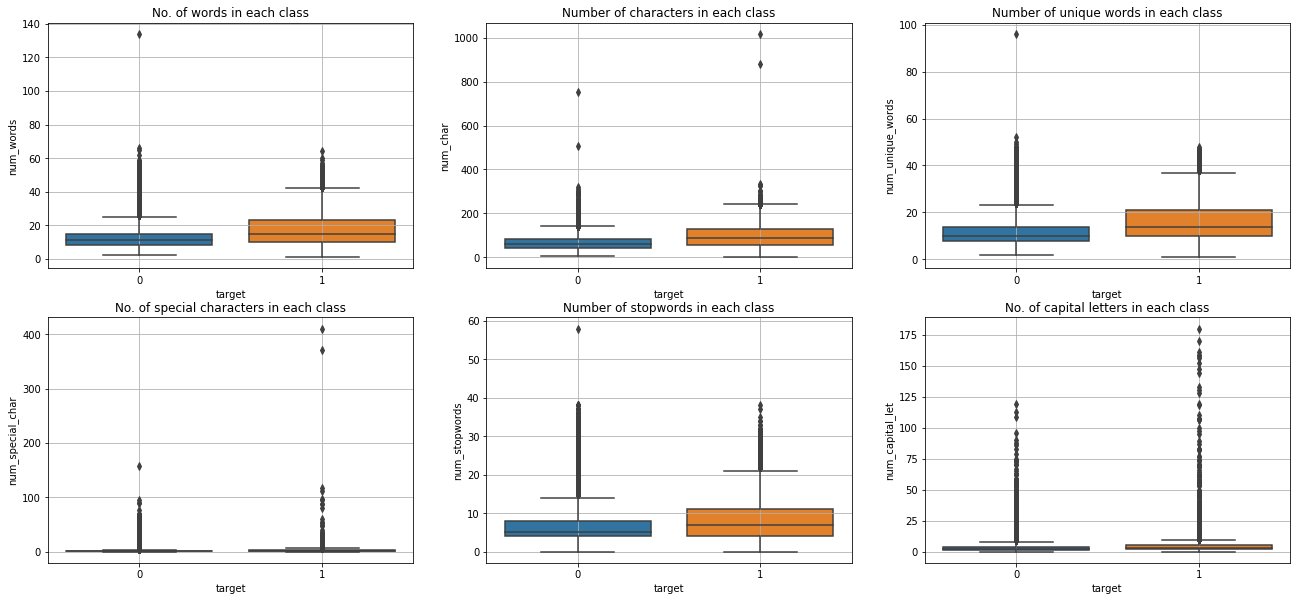

In [0]:
# Boxplot: Number of words
plt.subplot(2, 3, 1)
display_boxplot('target', 'num_words', df_train, 'No. of words in each class')

# Boxplot: Number of chars
plt.subplot(2, 3, 2)
display_boxplot('target', 'num_char', df_train, 'Number of characters in each class')

# Boxplot: Number of unique words
plt.subplot(2, 3, 3)
display_boxplot('target', 'num_unique_words', df_train, 'Number of unique words in each class')

# Boxplot: Number of special characters
plt.subplot(2, 3, 4)
display_boxplot('target', 'num_special_char', df_train, 'No. of special characters in each class')

# Boxplot: Number of stopwords
plt.subplot(2, 3, 5)
display_boxplot('target', 'num_stopwords', df_train, 'Number of stopwords in each class')

# Boxplot: Number of capital letters
plt.subplot(2, 3, 6)
display_boxplot('target', 'num_capital_let', df_train, 'No. of capital letters in each class')


plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

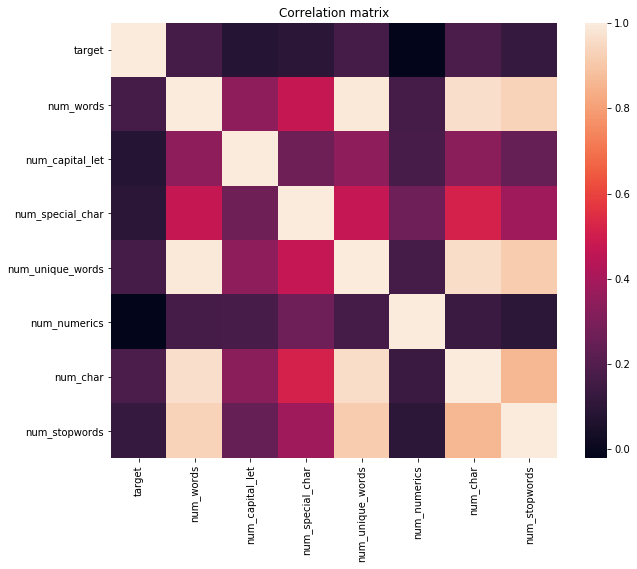

In [0]:
# Correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

__Observations__
- Insecure questions seems to have more words and characters.
- Insecure questions also have more unique words compare to sincere questions.

In [0]:
# Questions with most number of non-alphanumeric characters.
  # Insincere questions are printed in red color.

qids = df_train.sort_values('num_special_char', ascending=False)['qid'].head(20).values
for id in qids:
  row = df_train[df_train['qid'].values == id]
  if row['target'].values[0] == 1: 
    color = '\033[31m'
  else:
    color = '\033[0m'
  print(color, row['question_text'].values[0], '\n')

 What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\m

In [0]:
def get_all_symbols(data):
  """
  Returns SET: special symbols in corpus
  """
  
  symbols = []
  for text in data:
    s = re.findall(r'\W+', str(text))
    symbols.extend(s), 
  
  return set(symbols)

In [0]:
extracted_symbols = get_all_symbols(df_train['question_text'].values)
print(extracted_symbols)

{'ุ', ' \\| ^{', '(?) ', '!}\\', ' () () ', '>(', ' %?', '?"?', '+ + ', '"…) =', '"," "', '/=', ') =-\\', '}} [\\', ' {(\\', '))"', '. // ', ')} {\\', ',+', ') ; ', ' $\\ {', '̅)?', ':=', ' { \\', '” …', '’, ', '\u200b?', '..) ', "' ,'", '"… ', '}=-', ' ."?', '” (“', '? —', '].?', ') /∛(', ' ℃？?', ', ', ' £', ')+ ', '-×-×', '@ ', ',..) ', '“. ', '}<', '| < ', '⬇️', ' ⇒ ', ' − ', ']{\\', ' --', '™. ', ' = (', ' :(?', '?",', "…' ", '}}^{', ".'? ", ',…', '\u200b. ', ')). ', '.*?', '(', '. - ', ' (√', ' ✅ ', ': ‘', 'ี', 'िं', ', … ', '^ {(', 'ు) ', '／', ' -?', ':- ', '} + {', '<< ', ' -- -', ')-', '^(√', '|', '.[', '″ ', ']=', '!\\', '+ [', '″-', 'ៃ', '"--', '!”?', ' ⊂ ', '*? ', '}}}}{\\', ' → ', ' [*] ', '∧-', ' \xad ', ")' ", '. ” ', ' = ', ' *.*" ', '〗', '!)', ', %-', '↑↑↑↑', 'ी', ')] + ', ' |< ', ': \\', ' ("%', '? (# ', '])?', ' ]', ' # ', '?).', ']”=“', '";"?', '%. (', '=? ', '’ ?', '.).', ') \\,', '$, ', '⊆', ' ∫ (', '‑', "'(", '||', ' ~ ', ']? ?', '} \\, [/', '+% ', '. "…', ' \\ - 

__Observations:__
- Looks like there are some math questions(most of them are classified as insincere) in the data which contains more special chars and numbers.
- Some questions also contains emojis and non-english characters.
- Presence of punctuations in may add more value to ML models.